**Enhancing the Robustness of Neural Network-Based Intrusion Detection Systems Against DDoS Adversarial Attacks: A Study Using CICIDS2017**

In [1]:
import subprocess

# Get GPU information
gpu_info = subprocess.getoutput('nvidia-smi')
if 'failed' in gpu_info:
    print('Not connected to a GPU')
else:
    print(gpu_info)


Sat Jul 27 06:36:05 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   28C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Importing Libraries

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, LSTM
from tensorflow.keras.utils import to_categorical
from IPython.display import display, Markdown, Latex
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical


Original class distribution:
Label
BENIGN                      2273098
DoS Hulk                     231073
PortScan                     158930
DDoS                         128027
DoS GoldenEye                 10293
FTP-Patator                    7938
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1966
Web Attack_Brute Force         1507
Web Attack_XSS                  652
Infiltration                     36
Web Attack_Sql Injection         21
Heartbleed                       11
Name: count, dtype: int64

Class distribution after sampling:
Label
BENIGN                    80666
DoS Hulk                   8056
PortScan                   5447
DDoS                       4470
DoS GoldenEye               367
FTP-Patator                 273
SSH-Patator                 202
DoS slowloris               202
DoS Slowhttptest            160
Bot                          68
Web Attack_Brute Force       59
Web A

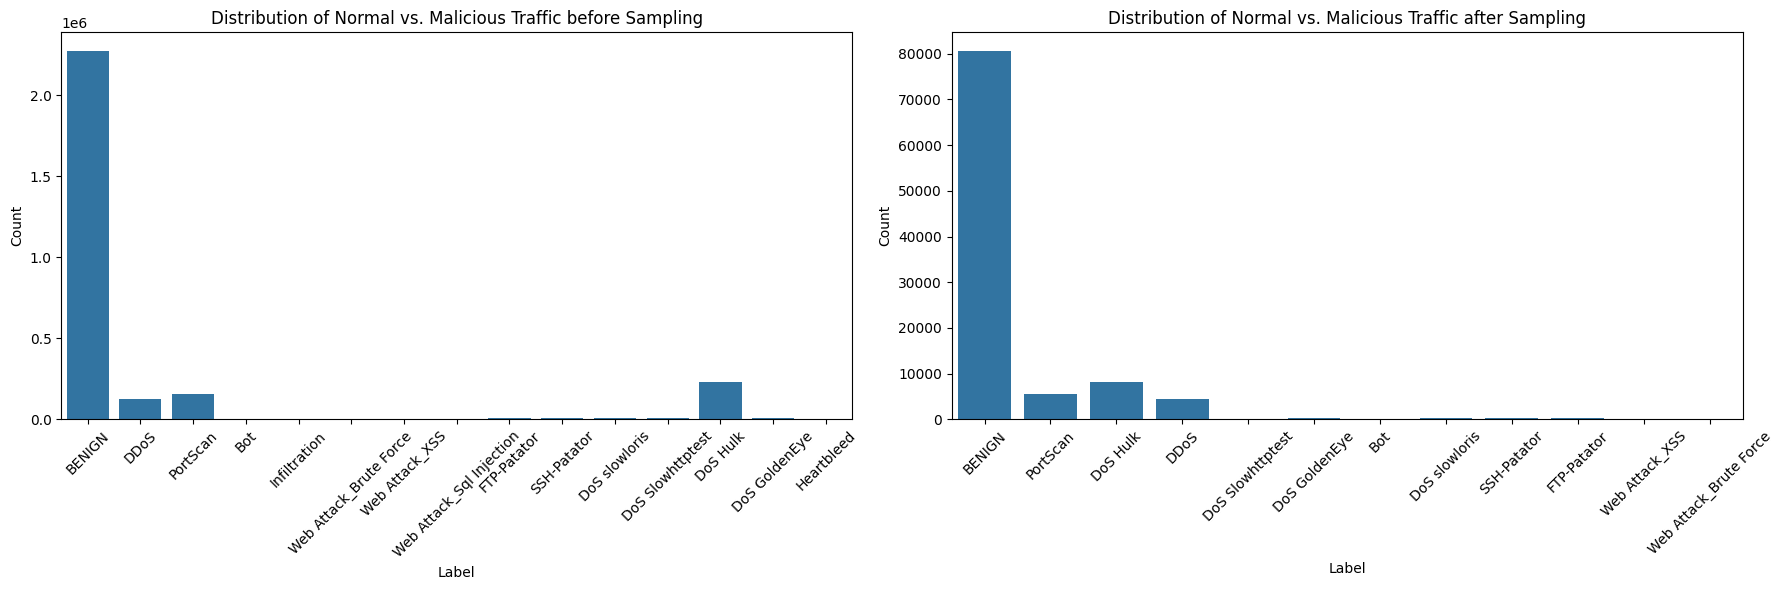

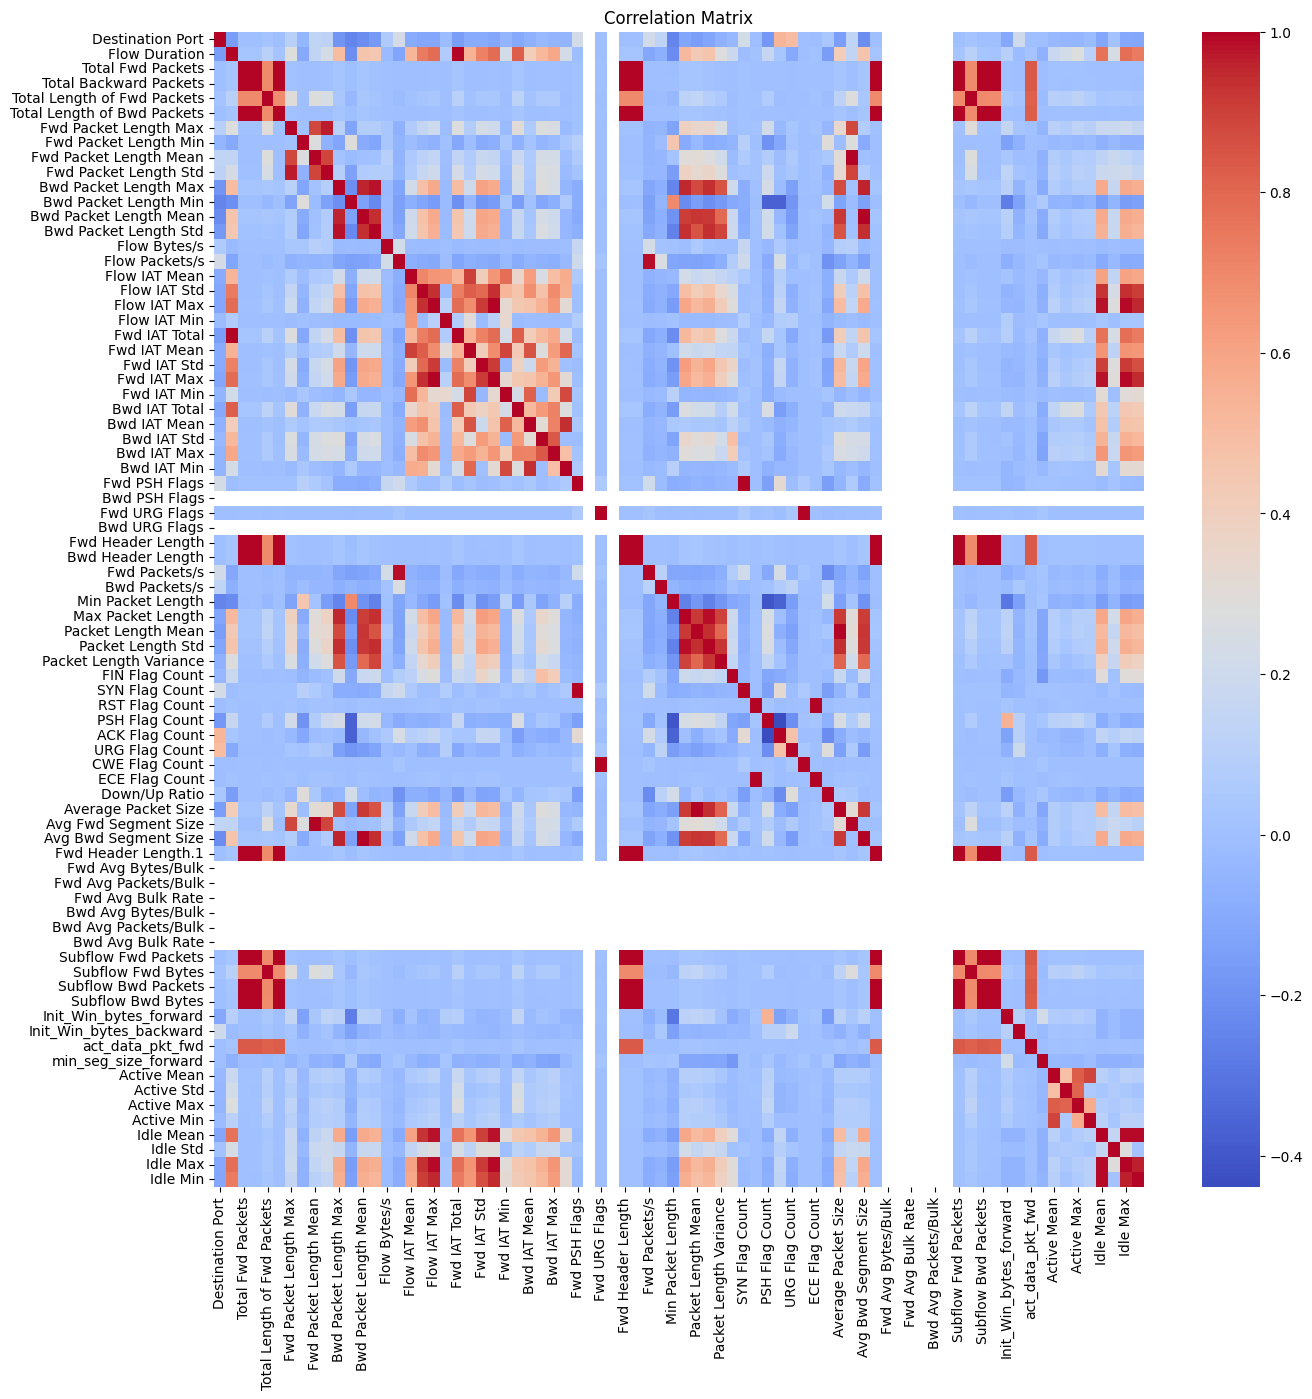

In [3]:
#Data Loading, Preprocessing, and Visualization


# Load the dataset in chunks
file_path = 'CICIDS2017.csv'
chunk_size = 10000  # Adjust chunk size based on memory constraints

# Initialize an empty DataFrame for appending processed chunks
df_list = []

# Process each chunk
for chunk in pd.read_csv(file_path, chunksize=chunk_size, low_memory=False):
    # Convert 'Destination Port' to numeric, forcing non-numeric values to NaN
    chunk[' Destination Port'] = pd.to_numeric(chunk[' Destination Port'], errors='coerce')

    # Handle missing values
    for col in chunk.select_dtypes(include=['float64']).columns:
        chunk[col].fillna(chunk[col].mean(), inplace=True)
    for col in chunk.select_dtypes(include=['object']).columns:
        chunk[col].fillna(chunk[col].mode()[0], inplace=True)
    
    # Replace infinity and extremely large values with NaN
    chunk.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill NaN values again after handling infinity values
    for col in chunk.select_dtypes(include=['float64']).columns:
        chunk[col].fillna(chunk[col].mean(), inplace=True)
    
    # Append the processed chunk to the list
    df_list.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(df_list, ignore_index=True)

# Remove the spaces before the column names
df.columns = df.columns.str.strip()

# Drop any rows with labels that are NaN (if any labels were not in the defined categories)
df.dropna(subset=['Label'], inplace=True)

# List of relevant features (excluding the 'Label' column)
features = df.columns[:-1]

# Initialize the StandardScaler
scaler = StandardScaler()

# Normalize the features
df[features] = scaler.fit_transform(df[features])

# Separate features and target variable
X = df[features]
y = df['Label']

# Display the original class distribution
print("Original class distribution:")
print(y.value_counts())

# Sample a smaller subset of the data to avoid memory issues
sample_size = 100000  # Adjust sample size based on your memory constraints
X_sampled = X.sample(n=sample_size, random_state=42)
y_sampled = y.sample(n=sample_size, random_state=42)

# Ensure sufficient samples in each class
min_samples = 6
sufficient_samples = y_sampled.value_counts() >= min_samples
sufficient_classes = sufficient_samples[sufficient_samples].index
X_sufficient = X_sampled[y_sampled.isin(sufficient_classes)]
y_sufficient = y_sampled[y_sampled.isin(sufficient_classes)]

# Convert the balanced data back to a DataFrame
df_sufficient = pd.DataFrame(X_sufficient, columns=features)
df_sufficient['Label'] = y_sufficient

# Display the class distribution after balancing
print("\nClass distribution after sampling:")
print(df_sufficient['Label'].value_counts())

# Display the original class distribution
plt.figure(figsize=(18, 6))

# Subplot 1: Distribution before sampling
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(x='Label', data=df)
plt.title('Distribution of Normal vs. Malicious Traffic before Sampling')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Subplot 2: Distribution after sampling
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(x='Label', data=df_sufficient)
plt.title('Distribution of Normal vs. Malicious Traffic after Sampling')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('Malicious_Traffic_after_Sampling.png', dpi=300, bbox_inches='tight')
# Show the plots
plt.show()

# Compute the correlation matrix excluding the 'Label' column
correlation_matrix = df_sufficient.drop(columns=['Label']).corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()




In [4]:
#Label Encoding and Data Splitting

# Encode the labels
label_encoder = LabelEncoder()
df_sufficient['Label'] = label_encoder.fit_transform(df_sufficient['Label'])

# Separate features and target variable
X = df_sufficient.drop(columns=['Label'])
y = df_sufficient['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (79999, 78)
Testing set shape: (20000, 78)


In [6]:
#Training and Evaluation of the Multi-Layer Perceptron (MLP) Model

# Suppress TensorFlow logging
tf.get_logger().setLevel(logging.ERROR)

# Define the MLP model
mlp_model = Sequential()
mlp_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
mlp_history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(X_test, y_test)
print("MLP Test Accuracy:", f"{mlp_test_acc * 100:.2f}")


Epoch 1/20


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9149 - loss: 0.3420 - val_accuracy: 0.9649 - val_loss: 0.0991
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9633 - loss: 0.0980 - val_accuracy: 0.9699 - val_loss: 0.0766
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9668 - loss: 0.0812 - val_accuracy: 0.9734 - val_loss: 0.0691
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9701 - loss: 0.0725 - val_accuracy: 0.9743 - val_loss: 0.0617
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9726 - loss: 0.0673 - val_accuracy: 0.9746 - val_loss: 0.0622
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9727 - loss: 0.0626 - val_accuracy: 0.9705 - val_loss: 0.0653
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9749 - loss: 0.0598 - val_accuracy: 0.9752 - val_loss: 0.0579
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9747 - loss: 0.0595 - val_accurac

In [7]:
#Convolutional Neural Network (CNN) Model Training and Evaluation

# Reshape data for CNN (1D)
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model with four convolutional layers
cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))  # First convolutional layer
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu'))  # Second convolutional layer
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(128, kernel_size=3, activation='relu'))  # Third convolutional layer
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(256, kernel_size=3, activation='relu'))  # Fourth convolutional layer
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_history = cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_cnn, y_test)
print("CNN Test Accuracy:", f"{cnn_test_acc * 100:.2f}")
tf.keras.backend.clear_session()

Epoch 1/20


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9189 - loss: 0.2984 - val_accuracy: 0.9688 - val_loss: 0.0794
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9661 - loss: 0.0827 - val_accuracy: 0.9730 - val_loss: 0.0730
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9709 - loss: 0.0678 - val_accuracy: 0.9736 - val_loss: 0.0606
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9728 - loss: 0.0609 - val_accuracy: 0.9749 - val_loss: 0.0646
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9764 - loss: 0.0573 - val_accuracy: 0.9756 - val_loss: 0.0593
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9762 - loss: 0.0558 - val_accuracy: 0.9771 - val_loss: 0.0528
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9789 - loss: 0.0499 - val_accuracy: 0.9766 - val_loss: 0.0511
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9797 - loss: 0.0482 - val_accura

In [8]:
#Implementation and Evaluation of LSTM-Based Recurrent Neural Network (RNN)
from tensorflow.keras.layers import LSTM

# Reshape data for RNN (LSTM)
X_train_rnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the RNN model (LSTM)
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_train_rnn.shape[1], 1)))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test_rnn, y_test)
print("RNN Test Accuracy:", f"{rnn_test_acc * 100:.2f}")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8312 - loss: 0.7565 - val_accuracy: 0.8469 - val_loss: 0.6078
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8481 - loss: 0.6051 - val_accuracy: 0.8535 - val_loss: 0.5822
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8560 - loss: 0.5742 - val_accuracy: 0.8604 - val_loss: 0.5636
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8594 - loss: 0.5537 - val_accuracy: 0.8701 - val_loss: 0.4495
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8881 - loss: 0.3370 - val_accuracy: 0.9294 - val_loss: 0.2169
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9209 - loss: 0.2366 - val_accuracy: 0.9399 - val_loss: 0.2129
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9223 - loss: 0.2297 - val_accuracy: 0.9293 - val_loss: 0.2113
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9309 - loss: 0

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.9793 - loss: 0.0466
MLP Test Accuracy: 97.93
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step


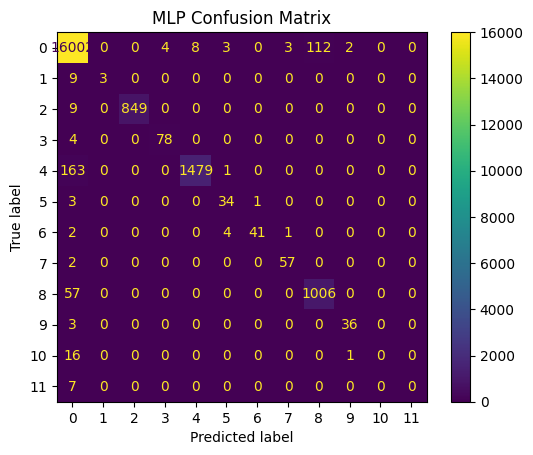

MLP Classification Report:
             precision recall f1-score  support
0                98.31  99.18    98.74    16134
1               100.00  25.00    40.00       12
2               100.00  98.95    99.47      858
3                95.12  95.12    95.12       82
4                99.46  90.02    94.50     1643
5                80.95  89.47    85.00       38
6                97.62  85.42    91.11       48
7                93.44  96.61    95.00       59
8                89.98  94.64    92.25     1063
9                92.31  92.31    92.31       39
10                0.00   0.00     0.00       17
11                0.00   0.00     0.00        7
accuracy         97.92  97.92    97.92        0
macro avg        78.93  72.23    73.63    20000
weighted avg     97.84  97.92    97.85    20000
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - accuracy: 0.9858 - loss: 0.0350
CNN Test Accuracy: 98.51
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step


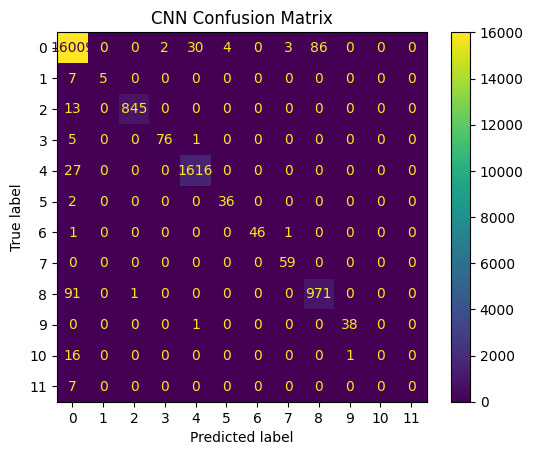

CNN Classification Report:
             precision  recall f1-score  support
0                98.96   99.23    99.09    16134
1               100.00   41.67    58.82       12
2                99.88   98.48    99.18      858
3                97.44   92.68    95.00       82
4                98.06   98.36    98.21     1643
5                90.00   94.74    92.31       38
6               100.00   95.83    97.87       48
7                93.65  100.00    96.72       59
8                91.86   91.35    91.60     1063
9                97.44   97.44    97.44       39
10                0.00    0.00     0.00       17
11                0.00    0.00     0.00        7
accuracy         98.50   98.50    98.50        0
macro avg        80.61   75.81    77.19    20000
weighted avg     98.39   98.50    98.44    20000
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9626 - loss: 0.1050
RNN Test Accuracy: 96.38
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


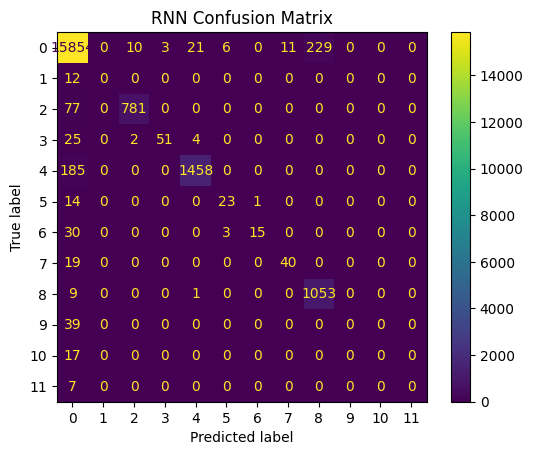

RNN Classification Report:
             precision recall f1-score  support
0                97.34  98.26    97.80    16134
1                 0.00   0.00     0.00       12
2                98.49  91.03    94.61      858
3                94.44  62.20    75.00       82
4                98.25  88.74    93.25     1643
5                71.88  60.53    65.71       38
6                93.75  31.25    46.88       48
7                78.43  67.80    72.73       59
8                82.14  99.06    89.81     1063
9                 0.00   0.00     0.00       39
10                0.00   0.00     0.00       17
11                0.00   0.00     0.00        7
accuracy         96.38  96.38    96.38        0
macro avg        59.56  49.90    52.98    20000
weighted avg     96.16  96.38    96.15    20000


In [9]:
#Visualization of Model Training and Validation Performance

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Evaluate the MLP model
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(X_test, y_test)
print(f"MLP Test Accuracy: {mlp_test_acc * 100:.2f}")

# Predict on test data
mlp_y_pred = np.argmax(mlp_model.predict(X_test), axis=1)

# Confusion Matrix for MLP
mlp_conf_matrix = confusion_matrix(y_test, mlp_y_pred)
ConfusionMatrixDisplay(mlp_conf_matrix).plot()
plt.title('MLP Confusion Matrix')
plt.show()

# Classification Report for MLP
mlp_class_report_dict = classification_report(y_test, mlp_y_pred, zero_division=0, output_dict=True)
mlp_class_report_df = pd.DataFrame(mlp_class_report_dict).transpose()

# Convert the metrics to percentages and format them to 2 decimal places
mlp_class_report_df['precision'] = (mlp_class_report_df['precision'] * 100).map('{:.2f}'.format)
mlp_class_report_df['recall'] = (mlp_class_report_df['recall'] * 100).map('{:.2f}'.format)
mlp_class_report_df['f1-score'] = (mlp_class_report_df['f1-score'] * 100).map('{:.2f}'.format)
mlp_class_report_df['support'] = mlp_class_report_df['support'].astype(int)

print("MLP Classification Report:")
print(mlp_class_report_df[['precision', 'recall', 'f1-score', 'support']])

# Similarly, you can repeat the process for CNN and RNN models

# CNN Model Evaluation
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_cnn, y_test)
print(f"CNN Test Accuracy: {cnn_test_acc * 100:.2f}")

# Predict on test data
cnn_y_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

# Confusion Matrix for CNN
cnn_conf_matrix = confusion_matrix(y_test, cnn_y_pred)
ConfusionMatrixDisplay(cnn_conf_matrix).plot()
plt.title('CNN Confusion Matrix')
plt.show()

# Classification Report for CNN
cnn_class_report_dict = classification_report(y_test, cnn_y_pred, zero_division=0, output_dict=True)
cnn_class_report_df = pd.DataFrame(cnn_class_report_dict).transpose()

# Convert the metrics to percentages and format them to 2 decimal places
cnn_class_report_df['precision'] = (cnn_class_report_df['precision'] * 100).map('{:.2f}'.format)
cnn_class_report_df['recall'] = (cnn_class_report_df['recall'] * 100).map('{:.2f}'.format)
cnn_class_report_df['f1-score'] = (cnn_class_report_df['f1-score'] * 100).map('{:.2f}'.format)
cnn_class_report_df['support'] = cnn_class_report_df['support'].astype(int)

print("CNN Classification Report:")
print(cnn_class_report_df[['precision', 'recall', 'f1-score', 'support']])

# RNN Model Evaluation
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test_rnn, y_test)
print(f"RNN Test Accuracy: {rnn_test_acc * 100:.2f}")

# Predict on test data
rnn_y_pred = np.argmax(rnn_model.predict(X_test_rnn), axis=1)

# Confusion Matrix for RNN
rnn_conf_matrix = confusion_matrix(y_test, rnn_y_pred)
ConfusionMatrixDisplay(rnn_conf_matrix).plot()
plt.title('RNN Confusion Matrix')
plt.show()

# Classification Report for RNN
rnn_class_report_dict = classification_report(y_test, rnn_y_pred, zero_division=0, output_dict=True)
rnn_class_report_df = pd.DataFrame(rnn_class_report_dict).transpose()

# Convert the metrics to percentages and format them to 2 decimal places
rnn_class_report_df['precision'] = (rnn_class_report_df['precision'] * 100).map('{:.2f}'.format)
rnn_class_report_df['recall'] = (rnn_class_report_df['recall'] * 100).map('{:.2f}'.format)
rnn_class_report_df['f1-score'] = (rnn_class_report_df['f1-score'] * 100).map('{:.2f}'.format)
rnn_class_report_df['support'] = rnn_class_report_df['support'].astype(int)

print("RNN Classification Report:")
print(rnn_class_report_df[['precision', 'recall', 'f1-score', 'support']])

Testing FGSM with epsilon = 0.05
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - accuracy: 0.8865 - loss: 0.8564
CNN Model Accuracy on FGSM (epsilon=0.05) Adversarial DDoS Attack: 0.8873
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step
Classification Report for FGSM (epsilon=0.05) Attack:
             precision recall f1-score  support
0                90.78  96.19    93.41    16134
1                 0.00   0.00     0.00       12
2                66.94  56.88    61.50      858
3                68.83  64.63    66.67       82
4                93.38  67.01    78.03     1643
5                40.91  23.68    30.00       38
6                51.52  35.42    41.98       48
7                 7.69   5.08     6.12       59
8                69.86  52.12    59.70     1063
9                 0.00   0.00     0.00       39
10                0.00   0.00     0.00       17
11                0.00   0.00     0.00        7
accuracy         88.72  88.72    88.72        0
macro avg        40.83  33.42    36.45    20000

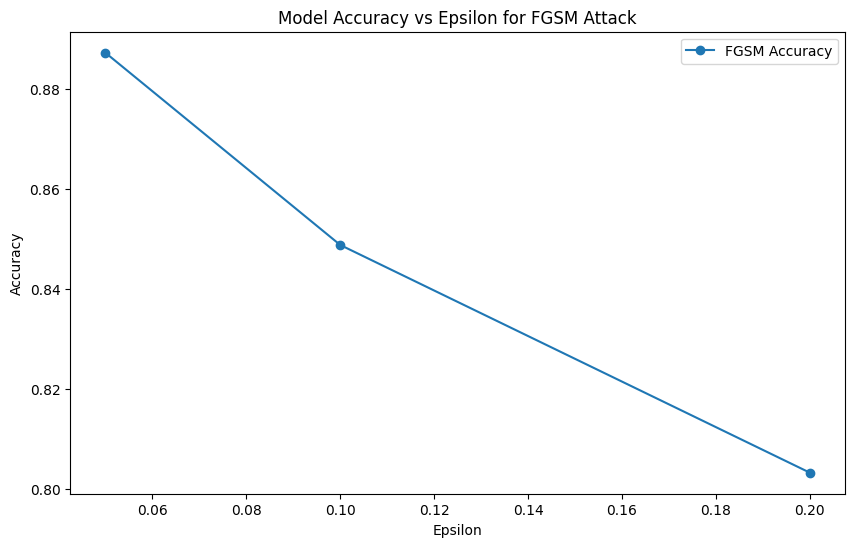

In [11]:
#Adversarial Example Generation and Evaluation using FGSM

from sklearn.metrics import classification_report, roc_auc_score

# Clear the TensorFlow session
tf.keras.backend.clear_session()

# Find the correct indices for the packet rate columns
fwd_packets_col_idx = df_sufficient.columns.get_loc('Fwd Packets/s')
bwd_packets_col_idx = df_sufficient.columns.get_loc('Bwd Packets/s')
flow_packets_col_idx = df_sufficient.columns.get_loc('Flow Packets/s')

# Function to create FGSM adversarial examples with rate manipulation
def fgsm_attack(model, X, y, epsilon, fwd_col_idx, bwd_col_idx, flow_col_idx):
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)
    
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        prediction = model(X_tensor)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, prediction)
    
    gradient = tape.gradient(loss, X_tensor)
    perturbation = epsilon * tf.sign(gradient)
    X_adversarial = X_tensor + perturbation

    # Convert the adversarial examples to numpy for manipulation
    X_adversarial_np = X_adversarial.numpy()

    # Introduce variations in packet rates
    random_variation_fwd = np.random.normal(0, epsilon / 2, size=X[:, fwd_col_idx].shape)
    random_variation_bwd = np.random.normal(0, epsilon / 2, size=X[:, bwd_col_idx].shape)
    random_variation_flow = np.random.normal(0, epsilon / 2, size=X[:, flow_col_idx].shape)

    X_adversarial_np[:, fwd_col_idx] += random_variation_fwd
    X_adversarial_np[:, bwd_col_idx] += random_variation_bwd
    X_adversarial_np[:, flow_col_idx] += random_variation_flow

    # Maintain feature correlations
    X_adversarial_np = maintain_feature_correlations(X_adversarial_np, fwd_col_idx, bwd_col_idx, flow_col_idx)

    return X_adversarial_np

# Helper function to maintain feature correlations in the packet rate columns
def maintain_feature_correlations(X_adversarial_np, fwd_col_idx, bwd_col_idx, flow_col_idx):
    for i in range(len(X_adversarial_np)):
        if X_adversarial_np[i, fwd_col_idx] > X_adversarial_np[i, flow_col_idx]:
            X_adversarial_np[i, fwd_col_idx] = X_adversarial_np[i, flow_col_idx] * np.random.uniform(0.8, 1.2)
        if X_adversarial_np[i, bwd_col_idx] > X_adversarial_np[i, flow_col_idx]:
            X_adversarial_np[i, bwd_col_idx] = X_adversarial_np[i, flow_col_idx] * np.random.uniform(0.8, 1.2)
    return X_adversarial_np

# Function to evaluate the model on adversarial examples
def evaluate_model_on_adversarial_examples(model, X_test_adv, y_test, attack_name):
    loss, accuracy = model.evaluate(X_test_adv, y_test)
    print(f'CNN Model Accuracy on {attack_name} Adversarial DDoS Attack: {accuracy:.4f}')
    
    y_pred = np.argmax(model.predict(X_test_adv), axis=1)
    
    # Generate classification report and convert to DataFrame
    classification_report_adv = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    classification_report_df = pd.DataFrame(classification_report_adv).transpose()
    
    # Convert the metrics to percentages and format them to 2 decimal places
    classification_report_df['precision'] = (classification_report_df['precision'] * 100).map('{:.2f}'.format)
    classification_report_df['recall'] = (classification_report_df['recall'] * 100).map('{:.2f}'.format)
    classification_report_df['f1-score'] = (classification_report_df['f1-score'] * 100).map('{:.2f}'.format)
    classification_report_df['support'] = classification_report_df['support'].astype(int)
    
    # Print the formatted classification report
    print(f"Classification Report for {attack_name} Attack:")
    print(classification_report_df[['precision', 'recall', 'f1-score', 'support']])
    
    # Calculate ROC-AUC score
    roc_auc_adv = roc_auc_score(y_test, model.predict(X_test_adv), multi_class="ovr")
    print(f"ROC-AUC on {attack_name} Attack: {roc_auc_adv:.4f}")
    
    return accuracy, loss, roc_auc_adv

# Define epsilon values to experiment with for FGSM
epsilon_values = [0.05, 0.1, 0.2]

# Results storage
results = []

# FGSM Attack with different epsilon values
for eps in epsilon_values:
    print(f"Testing FGSM with epsilon = {eps}")
    X_test_adv_fgsm = fgsm_attack(cnn_model, X_test_cnn, y_test, epsilon=eps, 
                                  fwd_col_idx=fwd_packets_col_idx, bwd_col_idx=bwd_packets_col_idx, 
                                  flow_col_idx=flow_packets_col_idx)
    fgsm_accuracy, fgsm_loss, fgsm_roc_auc = evaluate_model_on_adversarial_examples(cnn_model, X_test_adv_fgsm, y_test, f"FGSM (epsilon={eps})")
    results.append(('FGSM', eps, None, None, fgsm_accuracy, fgsm_loss, fgsm_roc_auc))

# Convert results to a DataFrame for easier analysis
columns = ['Attack', 'Epsilon', 'Alpha', 'Iterations', 'Accuracy', 'Loss', 'ROC_AUC']
results_df = pd.DataFrame(results, columns=columns)

# Plot results for accuracy vs epsilon for FGSM attack
plt.figure(figsize=(10, 6))
plt.plot(results_df['Epsilon'], results_df['Accuracy'], marker='o', label='FGSM Accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Epsilon for FGSM Attack')
plt.legend()
plt.show()


Testing PGD with epsilon = 0.05, alpha = 0.3, num_iterations = 40
CNN Model Accuracy on PGD (epsilon=0.05, alpha=0.3) Adversarial DDoS Attack: 0.8601
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step
Classification Report for PGD (epsilon=0.05, alpha=0.3) Attack:
             precision recall f1-score  support
0                88.57  95.55    91.93    16134
1                 0.00   0.00     0.00       12
2                62.25  54.78    58.28      858
3                52.33  54.88    53.57       82
4                88.15  66.10    75.55     1643
5                52.00  34.21    41.27       38
6                50.00  27.08    35.14       48
7                 0.00   0.00     0.00       59
8                41.13  15.05    22.04     1063
9                 0.00   0.00     0.00       39
10                0.00   0.00     0.00       17
11                0.00   0.00     0.00        7
accuracy         86.02  86.02    86.02        0
macro avg        36.20  28.97    31.48    20000
weighted avg     83.98 

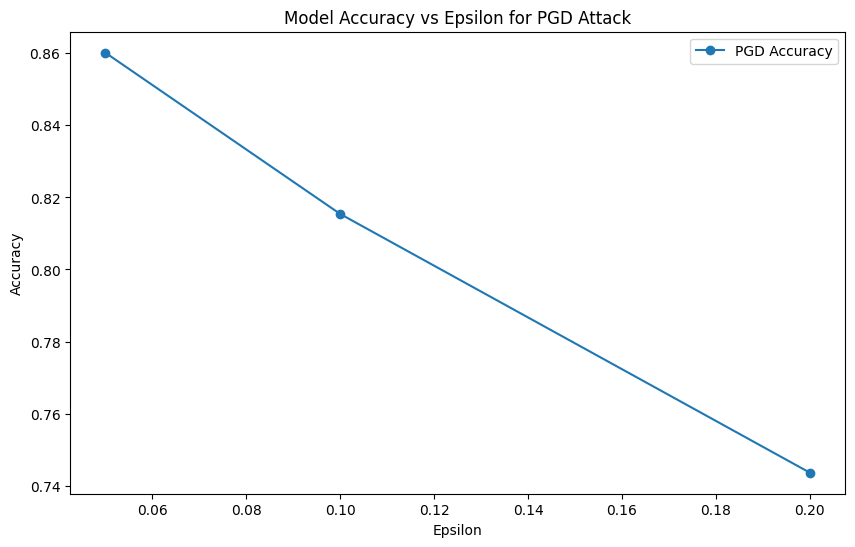

In [12]:
#Adversarial Example Generation and Evaluation using PGD

from sklearn.metrics import classification_report, roc_auc_score

# Ensure TensorFlow session is cleared
tf.keras.backend.clear_session()

# Find the correct indices for the packet rate columns
fwd_packets_col_idx = df_sufficient.columns.get_loc('Fwd Packets/s')
bwd_packets_col_idx = df_sufficient.columns.get_loc('Bwd Packets/s')
flow_packets_col_idx = df_sufficient.columns.get_loc('Flow Packets/s')

# Function to create PGD adversarial examples with rate manipulation
def pgd_attack(model, X, y, epsilon=0.2, alpha=0.3, num_iterations=40):
    X_adversarial = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)
    
    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(X_adversarial)
            prediction = model(X_adversarial)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, prediction)
        
        gradient = tape.gradient(loss, X_adversarial)
        perturbation = alpha * tf.sign(gradient)
        X_adversarial = tf.clip_by_value(X_adversarial + perturbation, X - epsilon, X + epsilon)

    X_adversarial_np = X_adversarial.numpy()

    # Introduce variations in packet rates
    random_variation_fwd = np.random.normal(0, epsilon / 2, size=X[:, fwd_packets_col_idx].shape)
    random_variation_bwd = np.random.normal(0, epsilon / 2, size=X[:, bwd_packets_col_idx].shape)
    random_variation_flow = np.random.normal(0, epsilon / 2, size=X[:, flow_packets_col_idx].shape)
    
    X_adversarial_np[:, fwd_packets_col_idx] += random_variation_fwd
    X_adversarial_np[:, bwd_packets_col_idx] += random_variation_bwd
    X_adversarial_np[:, flow_packets_col_idx] += random_variation_flow

    # Maintain feature correlations
    for i in range(len(X_adversarial_np)):
        if X_adversarial_np[i, fwd_packets_col_idx] > X_adversarial_np[i, flow_packets_col_idx]:
            X_adversarial_np[i, fwd_packets_col_idx] = X_adversarial_np[i, flow_packets_col_idx] * np.random.uniform(0.8, 1.2)
        if X_adversarial_np[i, bwd_packets_col_idx] > X_adversarial_np[i, flow_packets_col_idx]:
            X_adversarial_np[i, bwd_packets_col_idx] = X_adversarial_np[i, flow_packets_col_idx] * np.random.uniform(0.8, 1.2)

    return X_adversarial_np

# Function to evaluate the model on adversarial examples
def evaluate_model_on_adversarial_examples(model, X_test_adv, y_test, attack_name):
    loss, accuracy = model.evaluate(X_test_adv, y_test, verbose=0)
    print(f'CNN Model Accuracy on {attack_name} Adversarial DDoS Attack: {accuracy:.4f}')
    
    y_pred = np.argmax(model.predict(X_test_adv), axis=1)
    
    # Generate classification report and convert to DataFrame
    classification_report_adv = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    classification_report_df = pd.DataFrame(classification_report_adv).transpose()
    
    # Convert the metrics to percentages and format them to 2 decimal places
    classification_report_df['precision'] = (classification_report_df['precision'] * 100).map('{:.2f}'.format)
    classification_report_df['recall'] = (classification_report_df['recall'] * 100).map('{:.2f}'.format)
    classification_report_df['f1-score'] = (classification_report_df['f1-score'] * 100).map('{:.2f}'.format)
    classification_report_df['support'] = classification_report_df['support'].astype(int)
    
    # Print the formatted classification report
    print(f"Classification Report for {attack_name} Attack:")
    print(classification_report_df[['precision', 'recall', 'f1-score', 'support']])
    
    # Calculate ROC-AUC score
    roc_auc_adv = roc_auc_score(y_test, model.predict(X_test_adv), multi_class="ovr")
    print(f"ROC-AUC on {attack_name} Attack: {roc_auc_adv:.4f}")
    
    return accuracy, loss, roc_auc_adv

# Define the epsilon values to experiment with for PGD
epsilon_values = [0.05, 0.1, 0.2]
alpha = 0.3
num_iterations = 40

# Results storage
results = []

# PGD Attack with different epsilon values
for eps in epsilon_values:
    print(f"Testing PGD with epsilon = {eps}, alpha = {alpha}, num_iterations = {num_iterations}")
    X_test_adv_pgd = pgd_attack(cnn_model, X_test_cnn, y_test, epsilon=eps, alpha=alpha, num_iterations=num_iterations)
    pgd_accuracy, pgd_loss, pgd_roc_auc = evaluate_model_on_adversarial_examples(cnn_model, X_test_adv_pgd, y_test, f"PGD (epsilon={eps}, alpha={alpha})")
    results.append(('PGD', eps, alpha, num_iterations, pgd_accuracy, pgd_loss, pgd_roc_auc))

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Attack', 'Epsilon', 'Alpha', 'Iterations', 'Accuracy', 'Loss', 'ROC_AUC'])

# Plot results for accuracy vs epsilon for PGD attack
plt.figure(figsize=(10, 6))
plt.plot(results_df['Epsilon'], results_df['Accuracy'], marker='o', label='PGD Accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Epsilon for PGD Attack')
plt.legend()
plt.show()


Testing BIM with epsilon = 0.05, alpha = 0.3, num_iterations = 40
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.8644 - loss: 1.2105
CNN Model Accuracy on BIM (epsilon=0.05, alpha=0.3) Adversarial DDoS Attack: 0.8654
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step
Classification Report for BIM (epsilon=0.05, alpha=0.3) Attack:
             precision recall f1-score  support
0                89.49  95.07    92.20    16134
1                 0.00   0.00     0.00       12
2                62.68  55.01    58.60      858
3                49.45  54.88    52.02       82
4                88.38  65.73    75.39     1643
5                 7.69   5.26     6.25       38
6                37.50  25.00    30.00       48
7                 0.00   0.00     0.00       59
8                62.74  33.58    43.75     1063
9                 0.00   0.00     0.00       39
10                0.00   0.00     0.00       17
11                0.00   0.00     0.00        7
accuracy         86.53  86.53    86.53    

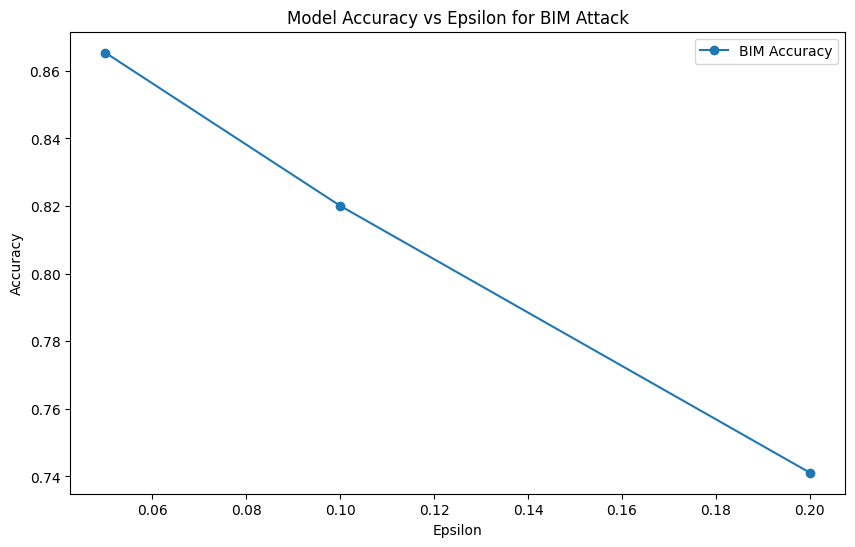

In [13]:
#Adversarial Example Generation and Evaluation using BIM

from sklearn.metrics import classification_report, roc_auc_score

# Optimized BIM attack with packet rate manipulation
def optimized_bim_attack(model, X, y, epsilon=0.2, alpha=0.3, num_iterations=40, fwd_col_idx=fwd_packets_col_idx, bwd_col_idx=bwd_packets_col_idx, flow_col_idx=flow_packets_col_idx):
    X_adversarial = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)
    
    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(X_adversarial)
            prediction = model(X_adversarial)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, prediction)
        
        gradient = tape.gradient(loss, X_adversarial)
        perturbation = alpha * tf.sign(gradient)
        X_adversarial = X_adversarial + perturbation
        X_adversarial = tf.clip_by_value(X_adversarial, X - epsilon, X + epsilon)
    
    X_adversarial_np = X_adversarial.numpy()

    # Handle the case where data has only one feature channel
    if X_adversarial_np.shape[2] == 1:
        # Apply perturbation directly on the first dimension
        random_variation_fwd = np.random.normal(0, epsilon / 2, size=X_adversarial_np[:, :, 0].shape)
        X_adversarial_np[:, :, 0] += random_variation_fwd
    else:
        # Introduce variations in packet rates for specific columns
        random_variation_fwd = np.random.normal(0, epsilon / 2, size=X_adversarial_np[:, :, fwd_col_idx].shape)
        random_variation_bwd = np.random.normal(0, epsilon / 2, size=X_adversarial_np[:, :, bwd_col_idx].shape)
        random_variation_flow = np.random.normal(0, epsilon / 2, size=X_adversarial_np[:, :, flow_col_idx].shape)
        
        X_adversarial_np[:, :, fwd_col_idx] += random_variation_fwd
        X_adversarial_np[:, :, bwd_col_idx] += random_variation_bwd
        X_adversarial_np[:, :, flow_col_idx] += random_variation_flow

        # Maintain feature correlations in a single loop
        for i in range(len(X_adversarial_np)):
            if X_adversarial_np[i, :, fwd_col_idx] > X_adversarial_np[i, :, flow_col_idx]:
                X_adversarial_np[i, :, fwd_col_idx] = X_adversarial_np[i, :, flow_col_idx] * np.random.uniform(0.8, 1.2)
            if X_adversarial_np[i, :, bwd_col_idx] > X_adversarial_np[i, :, flow_col_idx]:
                X_adversarial_np[i, :, bwd_col_idx] = X_adversarial_np[i, :, flow_col_idx] * np.random.uniform(0.8, 1.2)

    return X_adversarial_np

# Function to evaluate the model on adversarial examples
def evaluate_model_on_adversarial_examples(model, X_test_adv, y_test, attack_name):
    loss, accuracy = model.evaluate(X_test_adv, y_test)
    print(f'CNN Model Accuracy on {attack_name} Adversarial DDoS Attack: {accuracy:.4f}')
    
    y_pred = np.argmax(model.predict(X_test_adv), axis=1)
    
    # Generate classification report and convert to DataFrame
    classification_report_adv = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    classification_report_df = pd.DataFrame(classification_report_adv).transpose()
    
    # Convert the metrics to percentages and format them to 2 decimal places
    classification_report_df['precision'] = (classification_report_df['precision'] * 100).map('{:.2f}'.format)
    classification_report_df['recall'] = (classification_report_df['recall'] * 100).map('{:.2f}'.format)
    classification_report_df['f1-score'] = (classification_report_df['f1-score'] * 100).map('{:.2f}'.format)
    classification_report_df['support'] = classification_report_df['support'].astype(int)
    
    # Print the formatted classification report
    print(f"Classification Report for {attack_name} Attack:")
    print(classification_report_df[['precision', 'recall', 'f1-score', 'support']])
    
    # Calculate ROC-AUC score
    roc_auc_adv = roc_auc_score(y_test, model.predict(X_test_adv), multi_class="ovr")
    print(f"ROC-AUC on {attack_name} Attack: {roc_auc_adv:.4f}")
    
    return accuracy, loss, roc_auc_adv

# Define the epsilon values to experiment with for BIM
epsilon_values = [0.05, 0.1, 0.2]
alpha = 0.3
num_iterations = 40

# Results storage
results = []

# BIM Attack with different epsilon values
for eps in epsilon_values:
    print(f"Testing BIM with epsilon = {eps}, alpha = {alpha}, num_iterations = {num_iterations}")
    X_test_adv_bim = optimized_bim_attack(cnn_model, X_test_cnn, y_test, epsilon=eps, alpha=alpha, num_iterations=num_iterations)
    bim_accuracy, bim_loss, bim_roc_auc = evaluate_model_on_adversarial_examples(cnn_model, X_test_adv_bim, y_test, f"BIM (epsilon={eps}, alpha={alpha})")
    results.append(('BIM', eps, alpha, num_iterations, bim_accuracy, bim_loss, bim_roc_auc))

# Convert results to a DataFrame for easier analysis
columns = ['Attack', 'Epsilon', 'Alpha', 'Iterations', 'Accuracy', 'Loss', 'ROC_AUC']
results_df = pd.DataFrame(results, columns=columns)

# Plot results for accuracy vs epsilon for BIM attack
plt.figure(figsize=(10, 6))
plt.plot(results_df['Epsilon'], results_df['Accuracy'], marker='o', label='BIM Accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Epsilon for BIM Attack')
plt.legend()
plt.show()


Training with FGSM Adversarial examples (epsilon = 0.05)
Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 60s 23ms/step - accuracy: 0.9752 - loss: 0.0639 - val_accuracy: 0.9832 - val_loss: 0.0433
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - accuracy: 0.9818 - loss: 0.0485 - val_accuracy: 0.9844 - val_loss: 0.0430
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - accuracy: 0.9836 - loss: 0.0448 - val_accuracy: 0.9818 - val_loss: 0.0494
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - accuracy: 0.9851 - loss: 0.0412 - val_accuracy: 0.9823 - val_loss: 0.0434
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - accuracy: 0.9862 - loss: 0.0393 - val_accuracy: 0.9793 - val_loss: 0.0496
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - accuracy: 0.9875 - loss: 0.0350 - val_accuracy: 0.9796 - val_loss: 0.0468
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - accuracy: 0.9874 - loss: 0.0356 - val_accuracy: 0.9850 - val_loss: 0.0417
Epoch 8/10
2499/249

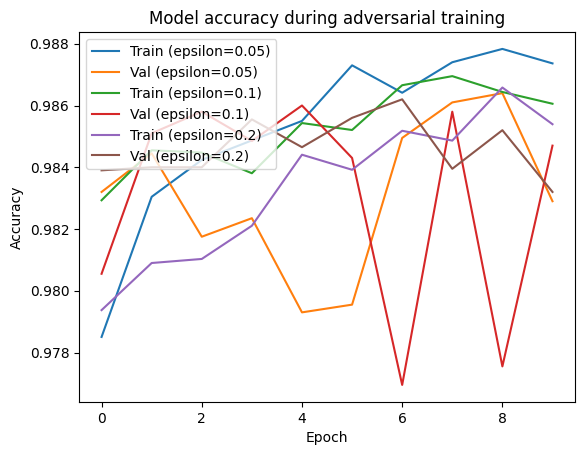

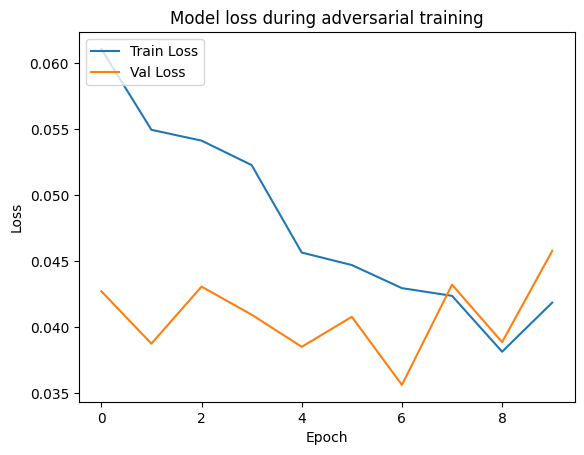

Adversarial Training Results:
   epsilon  train_accuracy  val_accuracy  test_accuracy
0     0.05        0.987364        0.9829         0.9920
1     0.10        0.986057        0.9847         0.9910
2     0.20        0.985394        0.9832         0.9824


In [15]:
#Adversarial Training for FGSM Attack

from sklearn.metrics import classification_report

# Ensure y_train and y_test are numpy arrays
y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_np = y_test.values if isinstance(y_test, pd.Series) else y_test

# Function to generate batches of original and adversarial examples for training
def adversarial_training_generator(model, X, y, batch_size, epsilon):
    while True:
        idx = np.random.randint(0, len(X), batch_size)
        X_batch = X[idx]
        y_batch = y[idx]
        X_adv_batch = fgsm_attack(model, X_batch, y_batch, epsilon=epsilon,
                                  fwd_col_idx=fwd_packets_col_idx, 
                                  bwd_col_idx=bwd_packets_col_idx, 
                                  flow_col_idx=flow_packets_col_idx)
        X_combined = np.vstack((X_batch, X_adv_batch))
        y_combined = np.hstack((y_batch, y_batch))
        yield X_combined, y_combined

# Set parameters for adversarial training
batch_size = 32
epochs = 10
training_results = []  # Store the results

# Loop over epsilon values for adversarial training
for eps in epsilon_values:
    print(f"Training with FGSM Adversarial examples (epsilon = {eps})")

    # Compile the model again to ensure it's ready for training
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model using adversarial examples
    cnn_adv_history = cnn_model.fit(
        adversarial_training_generator(cnn_model, X_train_cnn, y_train_np, batch_size=batch_size, epsilon=eps),
        steps_per_epoch=len(X_train_cnn) // batch_size,
        epochs=epochs,
        validation_data=(X_test_cnn, y_test_np)
    )

    # Generate FGSM adversarial examples with rate manipulation again
    X_test_adv_fgsm = fgsm_attack(cnn_model, X_test_cnn, y_test_np, epsilon=eps,
                                  fwd_col_idx=fwd_packets_col_idx, 
                                  bwd_col_idx=bwd_packets_col_idx, 
                                  flow_col_idx=flow_packets_col_idx)

    # Evaluate the CNN model on FGSM adversarial examples post-adversarial training
    cnn_loss_fgsm_adv_trained, cnn_accuracy_fgsm_adv_trained = cnn_model.evaluate(X_test_adv_fgsm, y_test_np)
    print(f'CNN Model Accuracy on FGSM Adversarial DDoS Attack (epsilon={eps}) Post-Adversarial Training: {cnn_accuracy_fgsm_adv_trained:.4f}')
    
    # Generate and format classification report
    y_pred = np.argmax(cnn_model.predict(X_test_adv_fgsm), axis=1)
    classification_report_dict = classification_report(y_test_np, y_pred, zero_division=0, output_dict=True)
    classification_report_df = pd.DataFrame(classification_report_dict).transpose()

    # Convert the metrics to percentages and format them to 2 decimal places
    classification_report_df['precision'] = (classification_report_df['precision'] * 100).map('{:.2f}'.format)
    classification_report_df['recall'] = (classification_report_df['recall'] * 100).map('{:.2f}'.format)
    classification_report_df['f1-score'] = (classification_report_df['f1-score'] * 100).map('{:.2f}'.format)
    classification_report_df['support'] = classification_report_df['support'].astype(int)

    # Print the formatted classification report
    print(f"Classification Report for FGSM Adversarial Attack (epsilon={eps}):")
    print(classification_report_df[['precision', 'recall', 'f1-score', 'support']])
    
    # Store the results
    training_results.append({
        'epsilon': eps,
        'train_accuracy': cnn_adv_history.history['accuracy'][-1],
        'val_accuracy': cnn_adv_history.history['val_accuracy'][-1],
        'test_accuracy': cnn_accuracy_fgsm_adv_trained
    })
    
    # Plot training & validation accuracy values
    plt.plot(cnn_adv_history.history['accuracy'], label=f'Train (epsilon={eps})')
    plt.plot(cnn_adv_history.history['val_accuracy'], label=f'Val (epsilon={eps})')

# Show and save combined accuracy plot
plt.title('Model accuracy during adversarial training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('fgsm_adversarial_training_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot and save training & validation loss values for the last epsilon value (could extend to all)
plt.plot(cnn_adv_history.history['loss'], label='Train Loss')
plt.plot(cnn_adv_history.history['val_loss'], label='Val Loss')
plt.title('Model loss during adversarial training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('fgsm_adversarial_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Convert the training results to a DataFrame for easier analysis
training_results_df = pd.DataFrame(training_results)

# Save the results to a CSV file for future reference
training_results_df.to_csv('fgsm_adversarial_training_results.csv', index=False)

# Display the final accuracy results
print("Adversarial Training Results:")
print(training_results_df)


Training and evaluating with epsilon = 0.05
Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 62s 24ms/step - accuracy: 0.9832 - loss: 0.0463 - val_accuracy: 0.9818 - val_loss: 0.0427
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - accuracy: 0.9878 - loss: 0.0336 - val_accuracy: 0.9855 - val_loss: 0.0387
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - accuracy: 0.9870 - loss: 0.0355 - val_accuracy: 0.9798 - val_loss: 0.0503
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - accuracy: 0.9848 - loss: 0.0399 - val_accuracy: 0.9866 - val_loss: 0.0374
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - accuracy: 0.9881 - loss: 0.0321 - val_accuracy: 0.9829 - val_loss: 0.0452
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - accuracy: 0.9867 - loss: 0.0353 - val_accuracy: 0.9841 - val_loss: 0.0384
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - accuracy: 0.9870 - loss: 0.0364 - val_accuracy: 0.9853 - val_loss: 0.0357
Epoch 8/10
2499/2499 ━━━━━━━━━━━

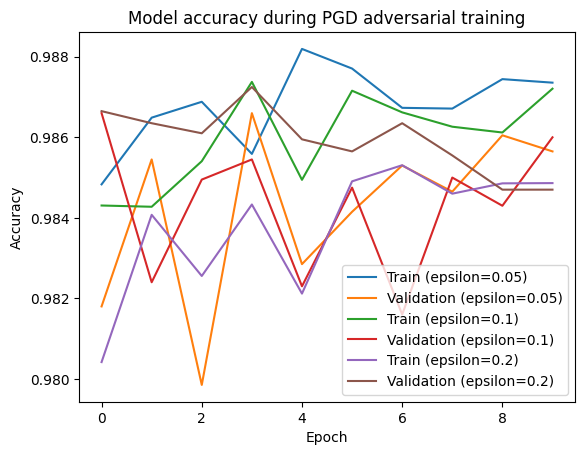

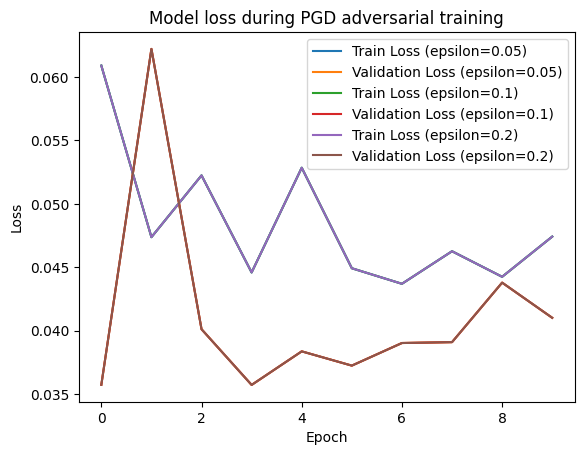

Adversarial Training Results:
   Epsilon  Accuracy      Loss
0     0.05   0.99190  0.032550
1     0.10   0.98450  0.053361
2     0.20   0.98295  0.051577

Classification Report for epsilon = 0.05:
             precision recall f1-score  support
0                99.47  99.57    99.52    16134
1                50.00   8.33    14.29       12
2                99.77  99.18    99.47      858
3                96.10  90.24    93.08       82
4                99.39  99.27    99.33     1643
5                84.62  86.84    85.71       38
6                97.56  83.33    89.89       48
7                94.92  94.92    94.92       59
8                95.66  99.62    97.60     1063
9                93.55  74.36    82.86       39
10                0.00   0.00     0.00       17
11                0.00   0.00     0.00        7
accuracy         99.19  99.19    99.19        0
macro avg        75.92  69.64    71.39    20000
weighted avg     99.05  99.19    99.11    20000

Classification Report for epsilon 

In [16]:
#Adversarial Training and Evaluation using PGD

from sklearn.metrics import classification_report

# Ensure y_train and y_test are numpy arrays
y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_np = y_test.values if isinstance(y_test, pd.Series) else y_test

# Function to generate batches of original and adversarial examples for training
def adversarial_training_generator_pgd(model, X, y, batch_size, epsilon, alpha, num_iterations): 
    while True:
        idx = np.random.randint(0, len(X), batch_size)
        X_batch = X[idx]
        y_batch = y[idx]
        X_adv_batch = pgd_attack(model, X_batch, y_batch, epsilon=epsilon, alpha=alpha, num_iterations=num_iterations)
        X_combined = np.vstack((X_batch, X_adv_batch))
        y_combined = np.hstack((y_batch, y_batch))
        yield X_combined, y_combined

# Set parameters for adversarial training
batch_size = 32
epochs = 10
alpha = 0.3
num_iterations = 1

# Results storage
results = []

# List of epsilon values to experiment with
epsilon_values = [0.05, 0.1, 0.2]

for epsilon in epsilon_values:
    print(f"Training and evaluating with epsilon = {epsilon}")

    # Re-compile the model before training
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model using PGD adversarial examples
    cnn_adv_pgd_history = cnn_model.fit(
        adversarial_training_generator_pgd(cnn_model, X_train_cnn, y_train_np, batch_size=batch_size, epsilon=epsilon, alpha=alpha, num_iterations=num_iterations),
        steps_per_epoch=len(X_train_cnn) // batch_size,
        epochs=epochs,
        validation_data=(X_test_cnn, y_test_np)
    )

    # Generate PGD adversarial examples with rate manipulation for the test set
    X_test_adv_pgd = pgd_attack(cnn_model, X_test_cnn, y_test_np, epsilon=epsilon, alpha=alpha, num_iterations=num_iterations)

    # Evaluate the CNN model on PGD adversarial examples post-adversarial training
    cnn_loss_pgd_adv_trained, cnn_accuracy_pgd_adv_trained = cnn_model.evaluate(X_test_adv_pgd, y_test_np)
    print(f'CNN Model Accuracy on PGD Adversarial DDoS Attack Post-Adversarial Training (epsilon={epsilon}): {cnn_accuracy_pgd_adv_trained:.4f}')

    # Generate classification report for the current model on adversarial examples
    y_pred = np.argmax(cnn_model.predict(X_test_adv_pgd), axis=1)
    class_report_dict = classification_report(y_test_np, y_pred, zero_division=0, output_dict=True)
    class_report_df = pd.DataFrame(class_report_dict).transpose()

    # Convert the metrics to percentages and format them to 2 decimal places
    class_report_df['precision'] = (class_report_df['precision'] * 100).map('{:.2f}'.format)
    class_report_df['recall'] = (class_report_df['recall'] * 100).map('{:.2f}'.format)
    class_report_df['f1-score'] = (class_report_df['f1-score'] * 100).map('{:.2f}'.format)
    class_report_df['support'] = class_report_df['support'].astype(int)

    # Print the formatted classification report
    print(f"Classification Report for PGD Adversarial Attack (epsilon={epsilon}):")
    print(class_report_df[['precision', 'recall', 'f1-score', 'support']])

    # Save the results for this epsilon value
    results.append((epsilon, cnn_accuracy_pgd_adv_trained, cnn_loss_pgd_adv_trained, class_report_df))

    # Plot training & validation accuracy values
    plt.plot(cnn_adv_pgd_history.history['accuracy'], label=f'Train (epsilon={epsilon})')
    plt.plot(cnn_adv_pgd_history.history['val_accuracy'], label=f'Validation (epsilon={epsilon})')

# Finalize the accuracy plot
plt.title('Model accuracy during PGD adversarial training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('pgd_adversarial_training_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training & validation loss values for each epsilon
for epsilon in epsilon_values:
    plt.plot(cnn_adv_pgd_history.history['loss'], label=f'Train Loss (epsilon={epsilon})')
    plt.plot(cnn_adv_pgd_history.history['val_loss'], label=f'Validation Loss (epsilon={epsilon})')

plt.title('Model loss during PGD adversarial training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('pgd_adversarial_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Convert results to DataFrame for easy analysis
results_df = pd.DataFrame(results, columns=['Epsilon', 'Accuracy', 'Loss', 'Classification Report'])

# Save the summary results to a CSV file
results_df.to_csv('pgd_adversarial_training_results.csv', index=False)

# Display the summary of results
print("Adversarial Training Results:")
print(results_df)


Training with BIM Adversarial examples (epsilon = 0.05, alpha = 0.3, num_iterations = 1)
Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - accuracy: 0.9753 - loss: 0.0663 - val_accuracy: 0.9717 - val_loss: 0.0669
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - accuracy: 0.9768 - loss: 0.0585 - val_accuracy: 0.9826 - val_loss: 0.0394
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - accuracy: 0.9836 - loss: 0.0432 - val_accuracy: 0.9814 - val_loss: 0.0501
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 56s 22ms/step - accuracy: 0.9815 - loss: 0.0477 - val_accuracy: 0.9850 - val_loss: 0.0383
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 56s 22ms/step - accuracy: 0.9813 - loss: 0.0486 - val_accuracy: 0.9851 - val_loss: 0.0430
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - accuracy: 0.9838 - loss: 0.0430 - val_accuracy: 0.9821 - val_loss: 0.0413
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - accuracy: 0.9843 - loss: 0.0430 - val_accuracy: 0.9865 - val_

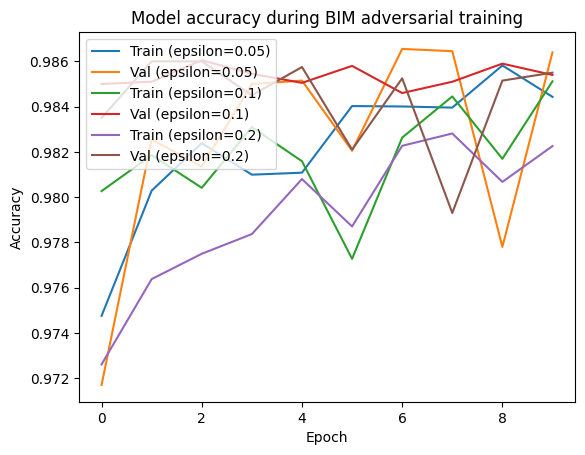

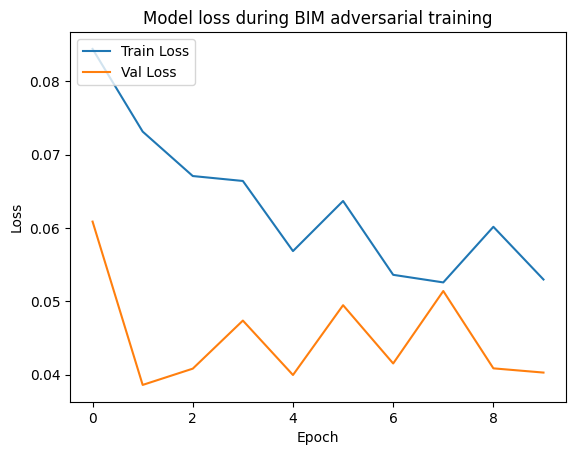

In [17]:
#Adversarial Training and Evaluation using BIM

from sklearn.metrics import classification_report

# Ensure y_train and y_test are numpy arrays
y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_np = y_test.values if isinstance(y_test, pd.Series) else y_test

# Function to generate batches of original and adversarial examples for training using BIM
def adversarial_training_generator_bim(model, X, y, batch_size, epsilon, alpha, num_iterations):
    while True:
        idx = np.random.randint(0, len(X), batch_size)
        X_batch = X[idx]
        y_batch = y[idx]
        X_adv_batch = optimized_bim_attack(model, X_batch, y_batch, epsilon=epsilon, alpha=alpha, num_iterations=num_iterations)
        X_combined = np.vstack((X_batch, X_adv_batch))
        y_combined = np.hstack((y_batch, y_batch))
        yield X_combined, y_combined

# Set parameters for adversarial training
batch_size = 32
epochs = 10
alpha = 0.3
num_iterations = 1

# List of epsilon values to experiment with
epsilon_values = [0.05, 0.1, 0.2]

# Results storage
bim_training_results = []

# Loop over epsilon values for adversarial training
for eps in epsilon_values:
    print(f"Training with BIM Adversarial examples (epsilon = {eps}, alpha = {alpha}, num_iterations = {num_iterations})")

    # Compile the model again to ensure it's ready for training
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model using BIM adversarial examples
    cnn_adv_bim_history = cnn_model.fit(
        adversarial_training_generator_bim(cnn_model, X_train_cnn, y_train_np, batch_size=batch_size, epsilon=eps, alpha=alpha, num_iterations=num_iterations),
        steps_per_epoch=len(X_train_cnn) // batch_size,
        epochs=epochs,
        validation_data=(X_test_cnn, y_test_np)
    )

    # Generate BIM adversarial examples with rate manipulation for the test set
    X_test_adv_bim = optimized_bim_attack(cnn_model, X_test_cnn, y_test_np, epsilon=eps, alpha=alpha, num_iterations=num_iterations)

    # Evaluate the CNN model on BIM adversarial examples post-adversarial training
    cnn_loss_bim_adv_trained, cnn_accuracy_bim_adv_trained = cnn_model.evaluate(X_test_adv_bim, y_test_np)
    print(f'CNN Model Accuracy on BIM Adversarial DDoS Attack (epsilon={eps}) Post-Adversarial Training: {cnn_accuracy_bim_adv_trained:.4f}')
    
    # Generate and format classification report
    y_pred = np.argmax(cnn_model.predict(X_test_adv_bim), axis=1)
    classification_report_dict = classification_report(y_test_np, y_pred, zero_division=0, output_dict=True)
    classification_report_df = pd.DataFrame(classification_report_dict).transpose()

    # Convert the metrics to percentages and format them to 2 decimal places
    classification_report_df['precision'] = (classification_report_df['precision'] * 100).map('{:.2f}'.format)
    classification_report_df['recall'] = (classification_report_df['recall'] * 100).map('{:.2f}'.format)
    classification_report_df['f1-score'] = (classification_report_df['f1-score'] * 100).map('{:.2f}'.format)
    classification_report_df['support'] = classification_report_df['support'].astype(int)

    # Print the formatted classification report
    print(f"Classification Report for BIM Adversarial Attack (epsilon={eps}):")
    print(classification_report_df[['precision', 'recall', 'f1-score', 'support']])

    # Store the results
    bim_training_results.append({
        'epsilon': eps,
        'train_accuracy': cnn_adv_bim_history.history['accuracy'][-1],
        'val_accuracy': cnn_adv_bim_history.history['val_accuracy'][-1],
        'test_accuracy': cnn_accuracy_bim_adv_trained
    })
    
    # Plot training & validation accuracy values
    plt.plot(cnn_adv_bim_history.history['accuracy'], label=f'Train (epsilon={eps})')
    plt.plot(cnn_adv_bim_history.history['val_accuracy'], label=f'Val (epsilon={eps})')

# Show combined accuracy plot and save the image
plt.title('Model accuracy during BIM adversarial training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('bim_adversarial_training_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training & validation loss values for the last epsilon value and save the image
plt.plot(cnn_adv_bim_history.history['loss'], label='Train Loss')
plt.plot(cnn_adv_bim_history.history['val_loss'], label='Val Loss')
plt.title('Model loss during BIM adversarial training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('bim_adversarial_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Convert the training results to a DataFrame for easier analysis
bim_training_results_df = pd.DataFrame(bim_training_results)

# Save the results to a CSV file for future reference
bim_training_results_df.to_csv('bim_adversarial_training_results.csv', index=False)


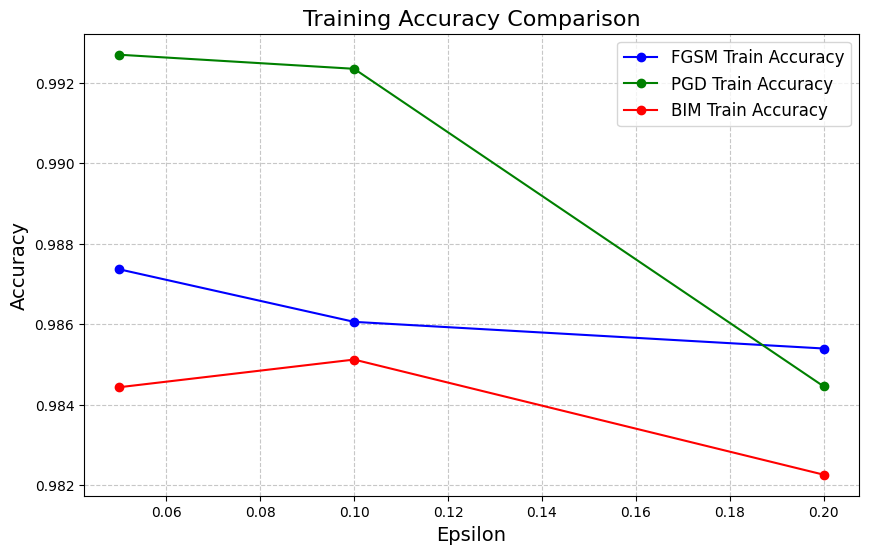

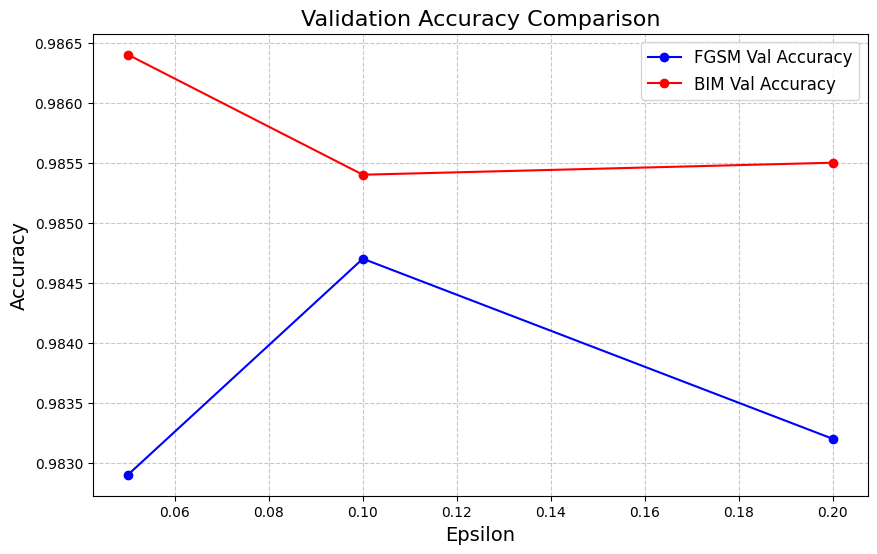

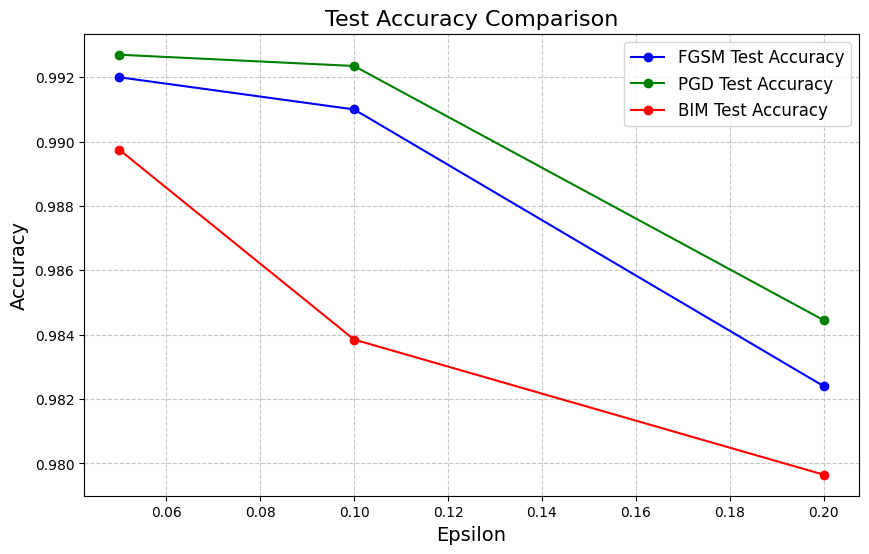

In [29]:
#Model Performance Analysis: Training, Validation, and Adversarial Evaluation

import matplotlib.pyplot as plt
# Load the data from CSV files
fgsm_results_df = pd.read_csv('fgsm_adversarial_training_results.csv')
pgd_results_df = pd.read_csv('pgd_adversarial_training_results.csv')
bim_results_df = pd.read_csv('bim_adversarial_training_results.csv')

# Plot comparison of training accuracy across different epsilon values for each adversarial technique
plt.figure(figsize=(10, 6))
plt.plot(fgsm_results_df['epsilon'], fgsm_results_df['train_accuracy'], label='FGSM Train Accuracy', marker='o', color='blue')
plt.plot(pgd_results_df['Epsilon'], pgd_results_df['Accuracy'], label='PGD Train Accuracy', marker='o', color='green')
plt.plot(bim_results_df['epsilon'], bim_results_df['train_accuracy'], label='BIM Train Accuracy', marker='o', color='red')
plt.title('Training Accuracy Comparison', fontsize=16)
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('train_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot comparison of validation accuracy across different epsilon values for each adversarial technique
plt.figure(figsize=(10, 6))
plt.plot(fgsm_results_df['epsilon'], fgsm_results_df['val_accuracy'], label='FGSM Val Accuracy', marker='o', color='blue')
plt.plot(bim_results_df['epsilon'], bim_results_df['val_accuracy'], label='BIM Val Accuracy', marker='o', color='red')
plt.title('Validation Accuracy Comparison', fontsize=16)
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('val_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot comparison of test accuracy across different epsilon values for each adversarial technique
plt.figure(figsize=(10, 6))
plt.plot(fgsm_results_df['epsilon'], fgsm_results_df['test_accuracy'], label='FGSM Test Accuracy', marker='o', color='blue')
plt.plot(pgd_results_df['Epsilon'], pgd_results_df['Accuracy'], label='PGD Test Accuracy', marker='o', color='green')
plt.plot(bim_results_df['epsilon'], bim_results_df['test_accuracy'], label='BIM Test Accuracy', marker='o', color='red')
plt.title('Test Accuracy Comparison', fontsize=16)
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('test_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

